In [1]:
import numpy as np
import torch
from data.synthetic_dataset import * #create_synthetic_dataset, SyntheticDataset , ECG5000Dataset,load_ECG5000
from models.seq2seq import EncoderRNN, DecoderRNN, Net_GRU
from loss.dilate_loss import dilate_loss
from torch.utils.data import DataLoader
import random
from tslearn.metrics import dtw, dtw_path
import matplotlib.pyplot as plt
import warnings
import warnings; warnings.simplefilter('ignore')


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
random.seed(0)

# parameters
batch_size = 100
N_input = 84
N_output = 56
sigma = 0.01
gamma = 0.01

# Load synthetic dataset
# X_train_input,X_train_target,X_test_input,X_test_target,train_bkp,test_bkp = create_synthetic_dataset(N,N_input,N_output,sigma)
# dataset_train = SyntheticDataset(X_train_input,X_train_target, train_bkp)
# dataset_test  = SyntheticDataset(X_test_input,X_test_target, test_bkp)
# trainloader = DataLoader(dataset_train, batch_size=batch_size,shuffle=True, num_workers=1)
# testloader  = DataLoader(dataset_test, batch_size=batch_size,shuffle=False, num_workers=1)


# Load ECG dataset
filepath_train = '../ECG5000_TRAIN.txt'
filepath_test = '../ECG5000_TEST.txt'
x_train_ip, x_train_op, x_test_ip, x_test_op, train_bkp, test_bkp = load_ECG5000(filepath_train, filepath_test)
# print (x_train_ip.shape, x_train_op.shape, x_test_ip.shape, x_test_op.shape)
dataset_train = create_Dataset(x_train_ip, x_train_op, train_bkp)
dataset_test  = create_Dataset(x_test_ip, x_test_op, test_bkp)
trainloader = DataLoader(dataset_train, batch_size=batch_size,shuffle=True, num_workers=1)
testloader  = DataLoader(dataset_test, batch_size=batch_size,shuffle=False, num_workers=1)

def train_model(net,loss_type, learning_rate, epochs=1000, gamma = 0.001,
                print_every=50,eval_every=50, verbose=1, Lambda=1, alpha=0.5):
    
    optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
    criterion = torch.nn.MSELoss()
    huber_loss = torch.nn.SmoothL1Loss()
    
    for epoch in range(epochs): 
        for i, data in enumerate(trainloader, 0):
            inputs, target, _ = data
            inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
            target = torch.tensor(target, dtype=torch.float32).to(device)
            batch_size, N_output = target.shape[0:2]                     

            # forward + backward + optimize
            outputs = net(inputs)
            loss_mse,loss_shape,loss_temporal = torch.tensor(0),torch.tensor(0),torch.tensor(0)
            
            if (loss_type=='mse'):
                loss_mse = criterion(target,outputs)
                loss = loss_mse                   
 
            if (loss_type=='dilate'):    
                loss, loss_shape, loss_temporal = dilate_loss(target,outputs,alpha, gamma, device)     
            
            if (loss_type=='dilate_shape'):    
                loss, loss_shape, loss_temporal = dilate_loss(target,outputs,alpha, gamma, device)     
                loss = loss_shape
            
            if (loss_type == 'huber'):
                loss = huber_loss(target, outputs)
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()          
        
        if(verbose):
            if (epoch % print_every == 0):
                print('epoch ', epoch, ' loss ',loss.item(),' loss shape ',loss_shape.item(),' loss temporal ',loss_temporal.item())
                eval_model(net,testloader, gamma,verbose=1)
  

 
def eval_model(net,loader, gamma,verbose=1):   
    criterion = torch.nn.MSELoss()
    losses_mse = []
    losses_dtw = []
    losses_tdi = []   

    for i, data in enumerate(loader, 0):
        loss_mse, loss_dtw, loss_tdi = torch.tensor(0),torch.tensor(0),torch.tensor(0)
        # get the inputs
        inputs, target, breakpoints = data
        inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
        target = torch.tensor(target, dtype=torch.float32).to(device)
        batch_size, N_output = target.shape[0:2]
        outputs = net(inputs)
         
        # MSE    
        loss_mse = criterion(target,outputs)    
        loss_dtw, loss_tdi = 0,0
        # DTW and TDI
        for k in range(batch_size):         
            target_k_cpu = target[k,:,0:1].view(-1).detach().cpu().numpy()
            output_k_cpu = outputs[k,:,0:1].view(-1).detach().cpu().numpy()

            loss_dtw += dtw(target_k_cpu,output_k_cpu)
            path, sim = dtw_path(target_k_cpu, output_k_cpu)   
                       
            Dist = 0
            for i,j in path:
                    Dist += (i-j)*(i-j)
            loss_tdi += Dist / (N_output*N_output)            
                        
        loss_dtw = loss_dtw /batch_size
        loss_tdi = loss_tdi / batch_size

        # print statistics
        losses_mse.append( loss_mse.item() )
        losses_dtw.append( loss_dtw )
        losses_tdi.append( loss_tdi )

    print( ' Eval mse= ', np.array(losses_mse).mean() ,' dtw= ',np.array(losses_dtw).mean() ,' tdi= ', np.array(losses_tdi).mean()) 


encoder = EncoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, batch_size=batch_size).to(device)
decoder = DecoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1,fc_units=16, output_size=1).to(device)
net_gru_dilate = Net_GRU(encoder,decoder, N_output, device).to(device)
train_model(net_gru_dilate,loss_type='dilate',learning_rate=0.001, epochs=1000, gamma=gamma, print_every=50, eval_every=50,verbose=1)

encoder = EncoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, batch_size=batch_size).to(device)
decoder = DecoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1,fc_units=16, output_size=1).to(device)
net_gru_mse = Net_GRU(encoder,decoder, N_output, device).to(device)
train_model(net_gru_mse,loss_type='mse',learning_rate=0.001, epochs=1000, gamma=gamma, print_every=50, eval_every=50,verbose=1)

encoder = EncoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, batch_size=batch_size).to(device)
decoder = DecoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1,fc_units=16, output_size=1).to(device)
net_gru_dilate_shape = Net_GRU(encoder,decoder, N_output, device).to(device)
train_model(net_gru_dilate_shape,loss_type='dilate_shape',learning_rate=0.001, epochs=1000, gamma=gamma, print_every=50, eval_every=50,verbose=1)


# HUBER LOSS
encoder = EncoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, batch_size=batch_size).to(device)
decoder = DecoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1,fc_units=16, output_size=1).to(device)
net_gru_huber = Net_GRU(encoder,decoder, N_output, device).to(device)
train_model(net_gru_huber,loss_type='huber',learning_rate=0.001, epochs=1000, gamma=gamma, print_every=50, eval_every=50,verbose=1)






epoch  0  loss  4.097583770751953  loss shape  6.408916473388672  loss temporal  1.7862515449523926
 Eval mse=  0.11412653310431374  dtw=  2.5085597217381888  tdi=  0.18737372448979586
epoch  50  loss  0.8686749339103699  loss shape  0.8902094960212708  loss temporal  0.847140371799469
 Eval mse=  0.029790398561292224  dtw=  1.208290241165524  tdi=  4.142194373582766
epoch  100  loss  1.1230146884918213  loss shape  0.8285580277442932  loss temporal  1.4174714088439941
 Eval mse=  0.029024307222829924  dtw=  1.2075985829873854  tdi=  4.16037429138322
epoch  150  loss  0.6318113803863525  loss shape  0.4046742916107178  loss temporal  0.8589485287666321
 Eval mse=  0.026597673901253276  dtw=  0.9723535825868819  tdi=  1.7161252125850337
epoch  200  loss  0.3313440978527069  loss shape  -0.035447876900434494  loss temporal  0.6981360912322998
 Eval mse=  0.02303749140765932  dtw=  0.6954127992713578  tdi=  1.057234268707483
epoch  250  loss  0.24389371275901794  loss shape  -0.1345136165

epoch  350  loss  -0.5576372146606445  loss shape  -0.5576372146606445  loss temporal  0.28126463294029236
 Eval mse=  0.012388380513423019  dtw=  0.3692216573817309  tdi=  0.3893088151927438
epoch  400  loss  -0.5588223338127136  loss shape  -0.5588223338127136  loss temporal  0.34848493337631226
 Eval mse=  0.012386352455036508  dtw=  0.3629534804362473  tdi=  0.4186481009070296
epoch  450  loss  -0.5189403295516968  loss shape  -0.5189403295516968  loss temporal  0.40711840987205505
 Eval mse=  0.012217030891527732  dtw=  0.33205285278752306  tdi=  0.3826276218820862
epoch  500  loss  -0.5655291080474854  loss shape  -0.5655291080474854  loss temporal  0.41878610849380493
 Eval mse=  0.011800468899309635  dtw=  0.32819872954907375  tdi=  0.38088747165532877
epoch  550  loss  -0.5913683772087097  loss shape  -0.5913683772087097  loss temporal  0.25696128606796265
 Eval mse=  0.011097098949054878  dtw=  0.32580408348588785  tdi=  0.37362733843537416
epoch  600  loss  -0.55354958772659

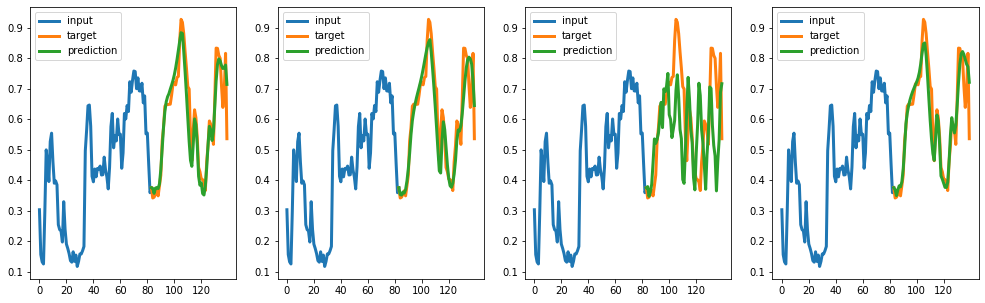

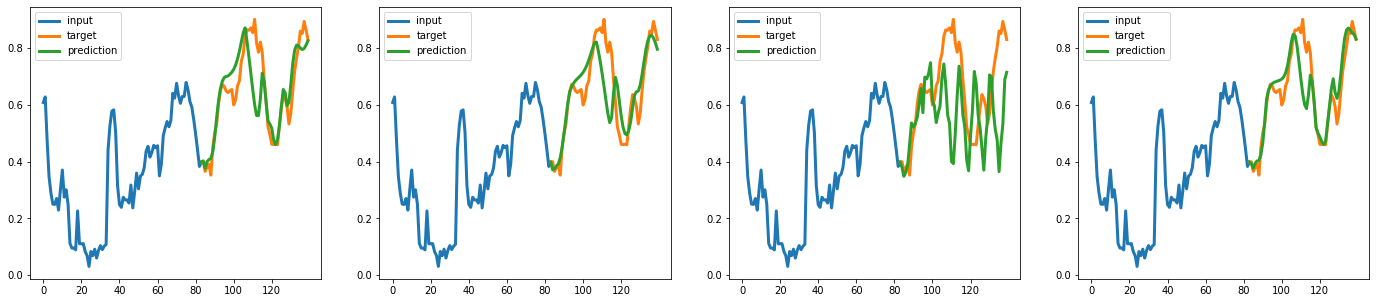

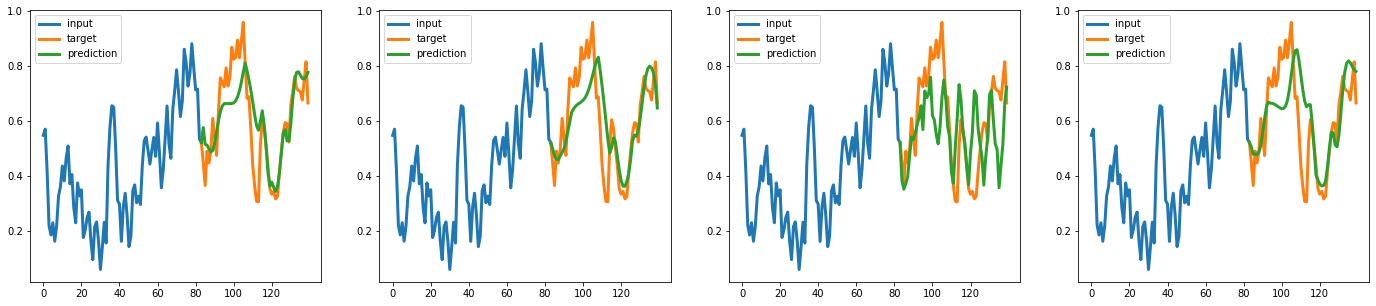

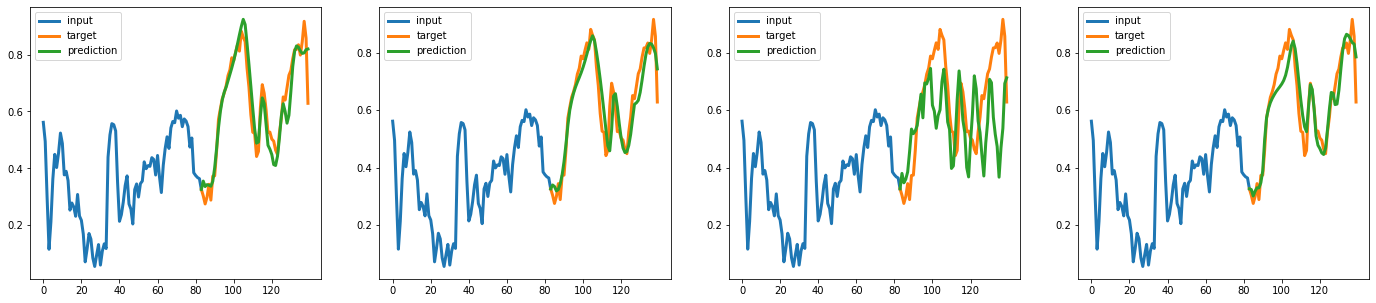

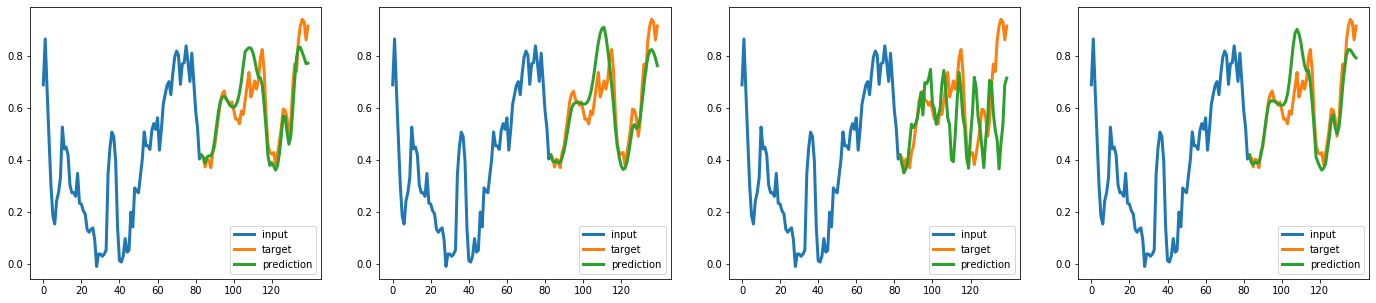

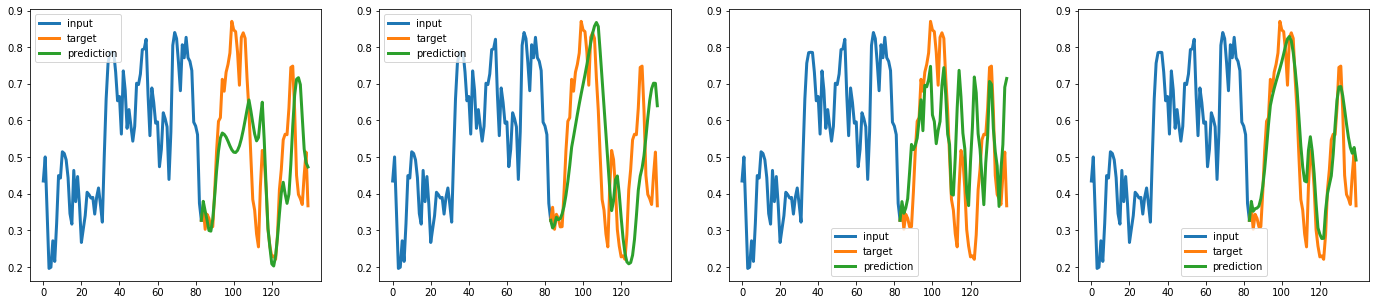

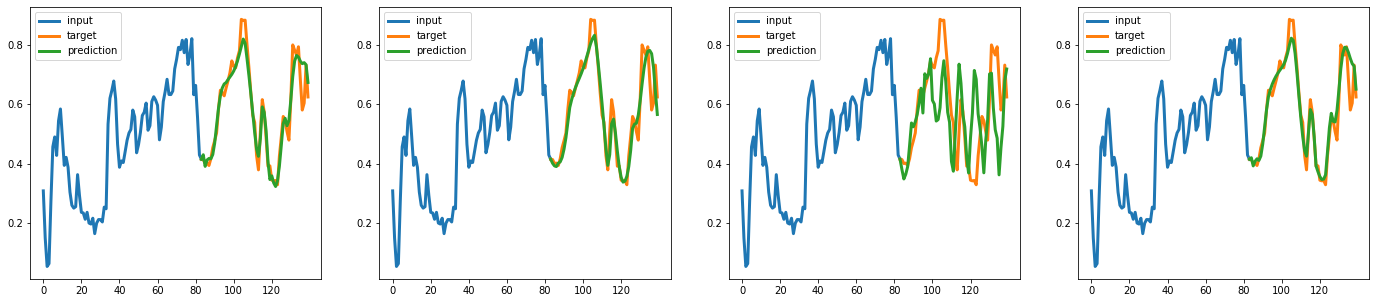

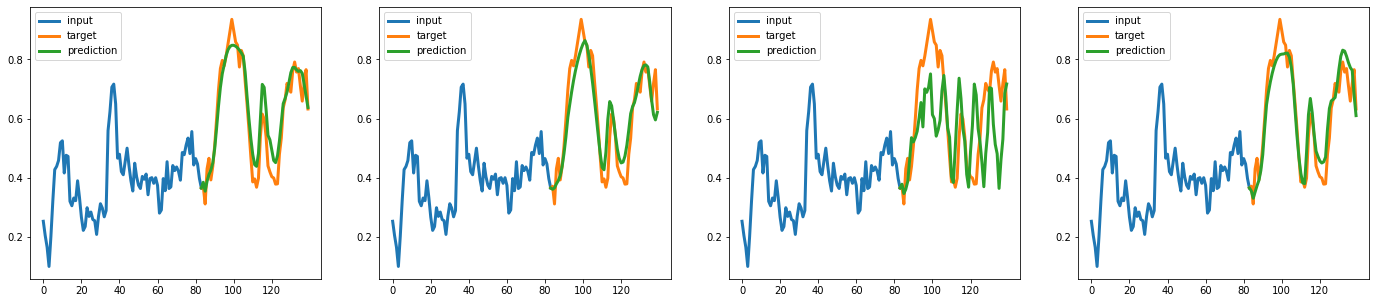

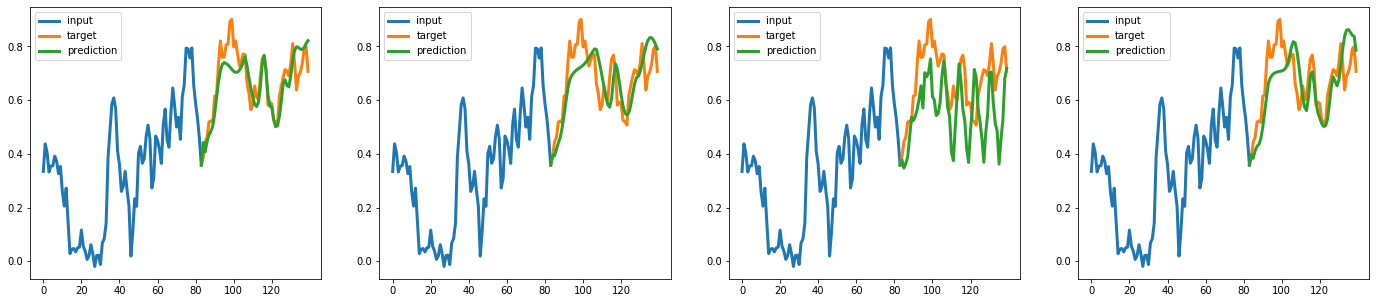

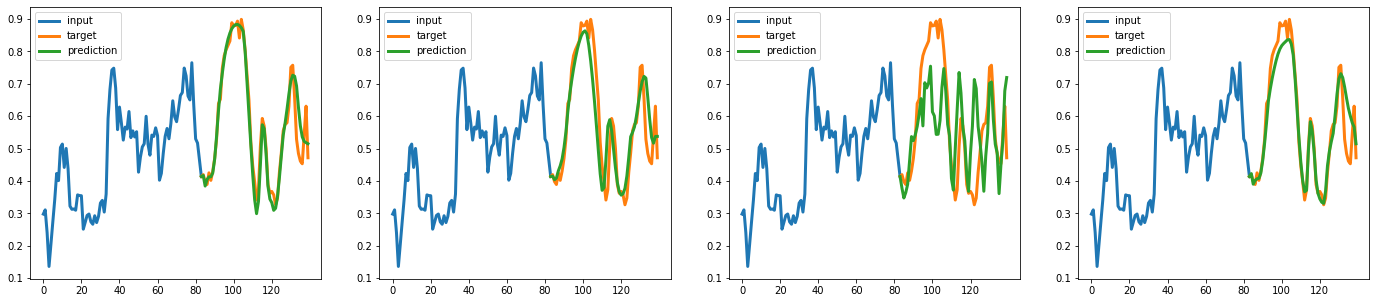

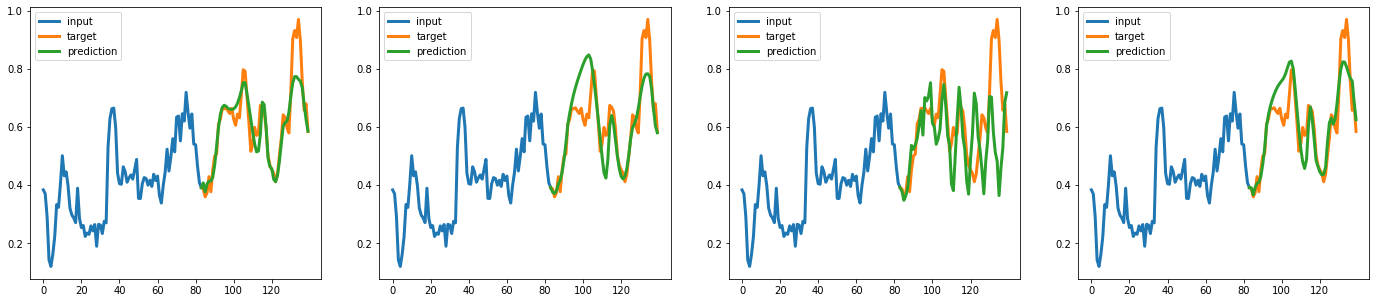

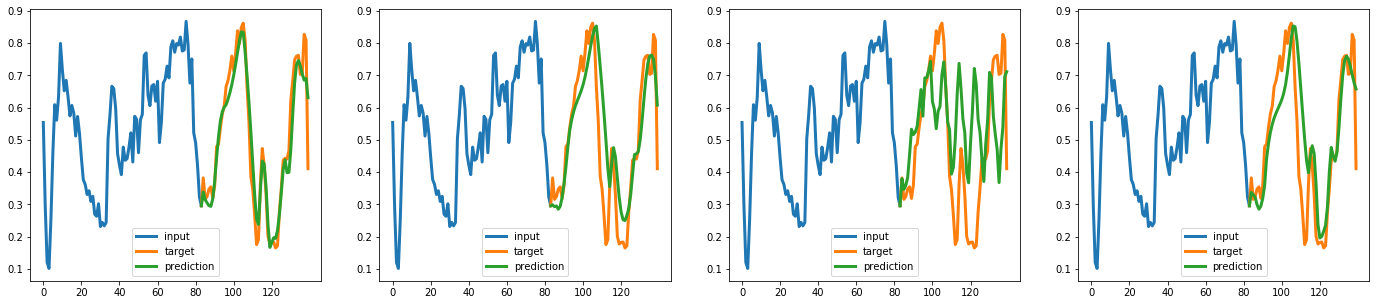

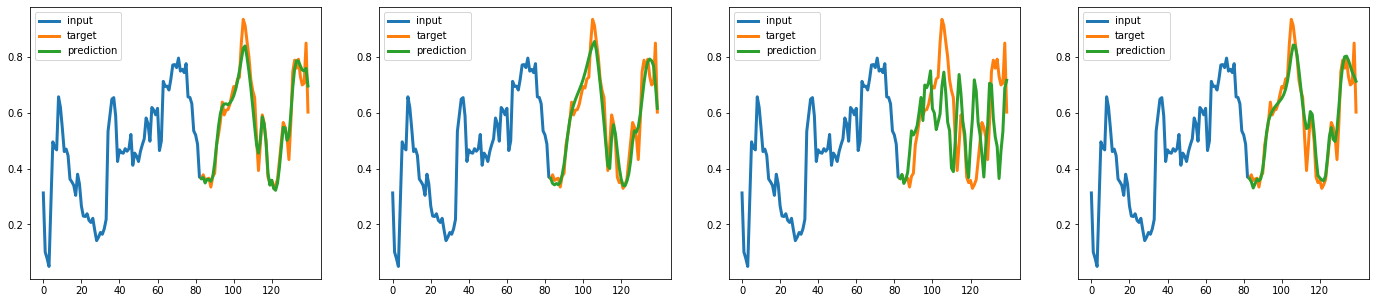

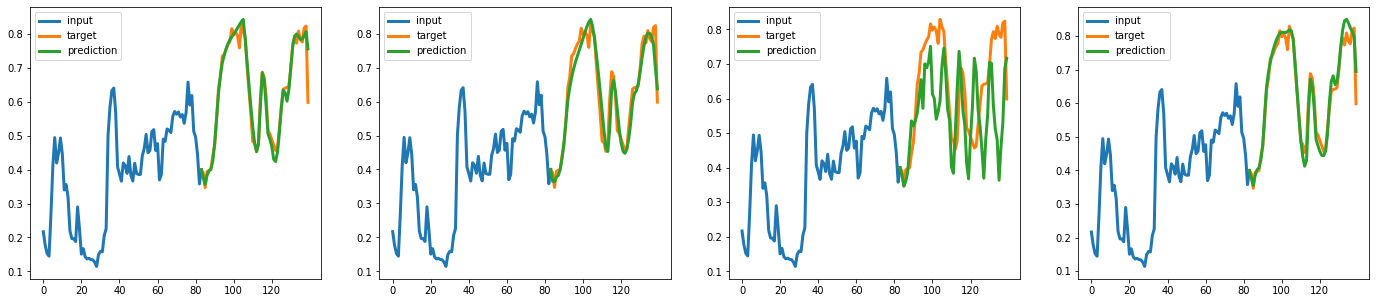

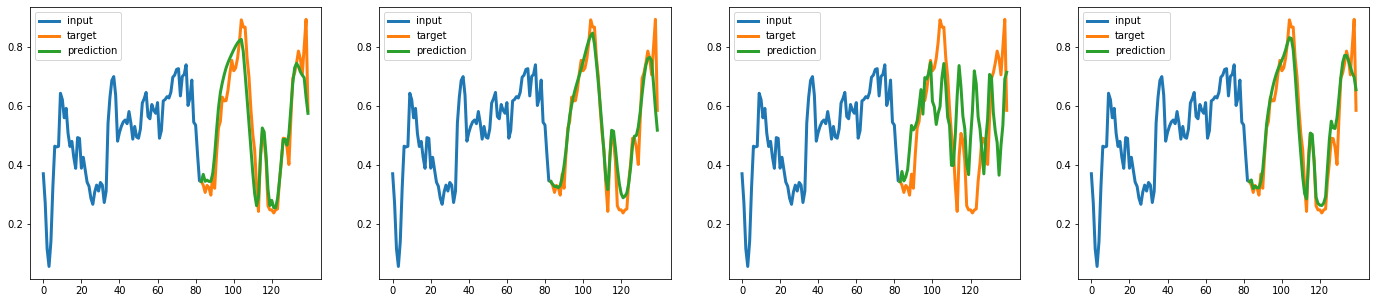

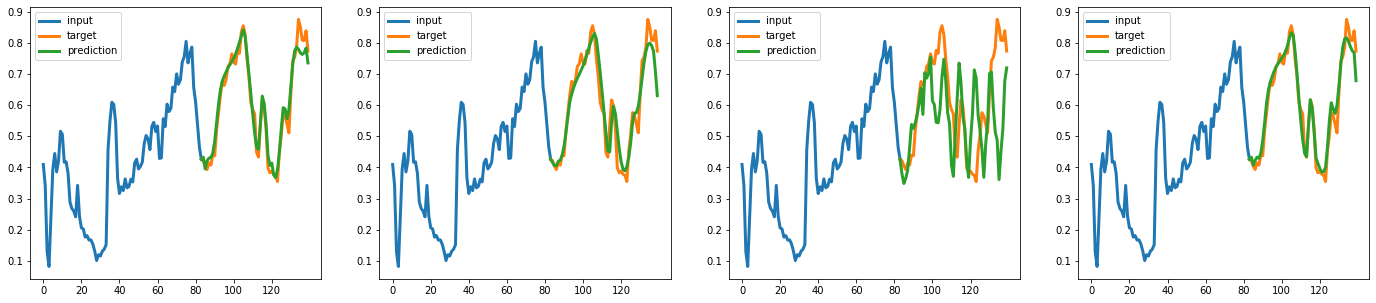

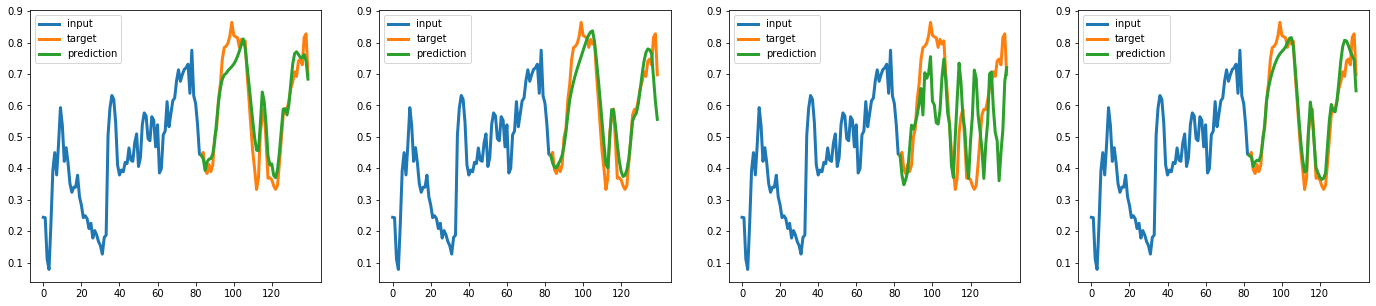

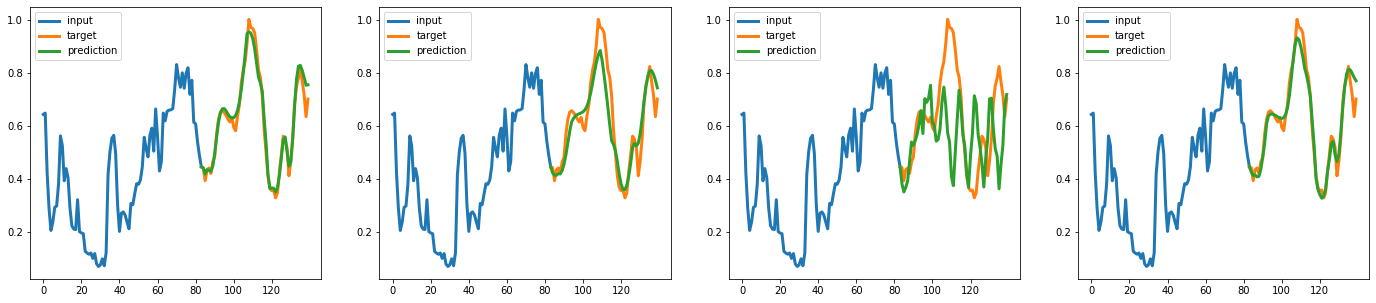

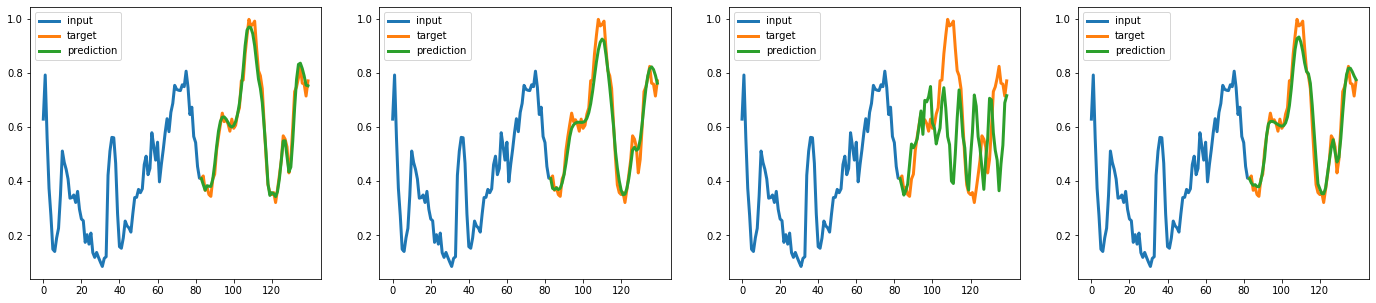

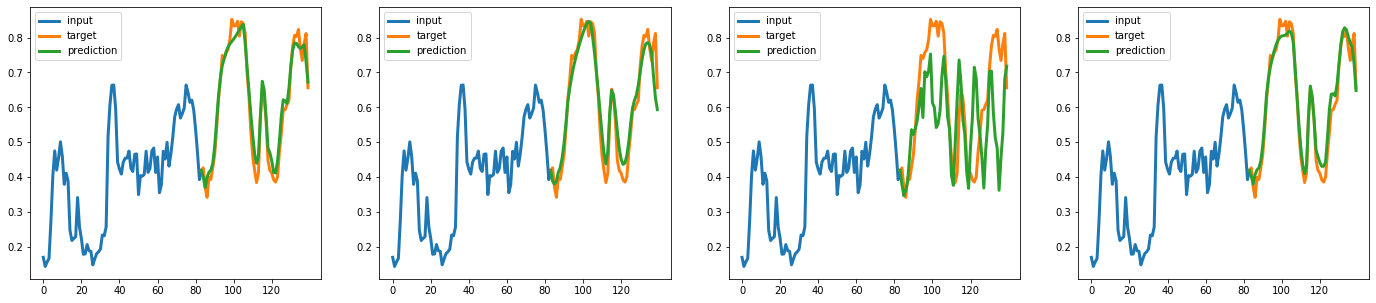

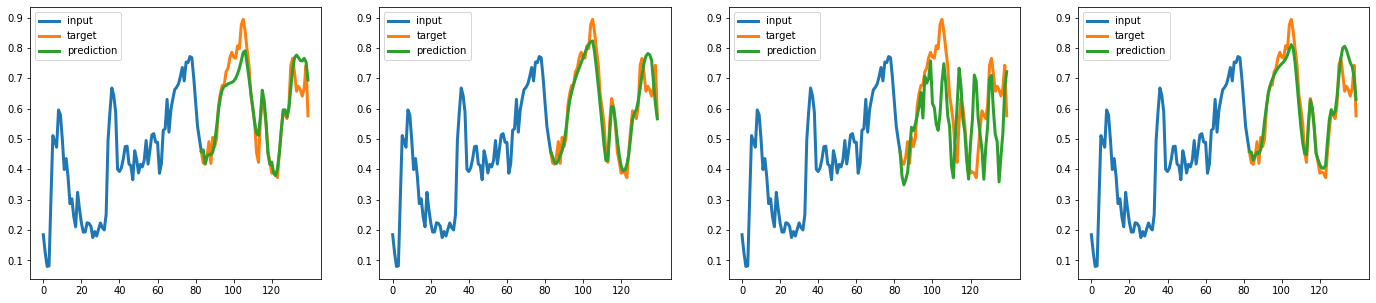

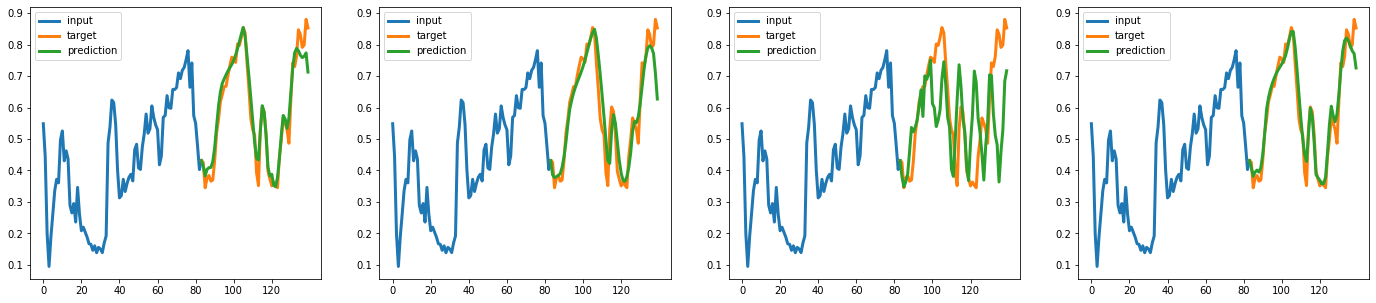

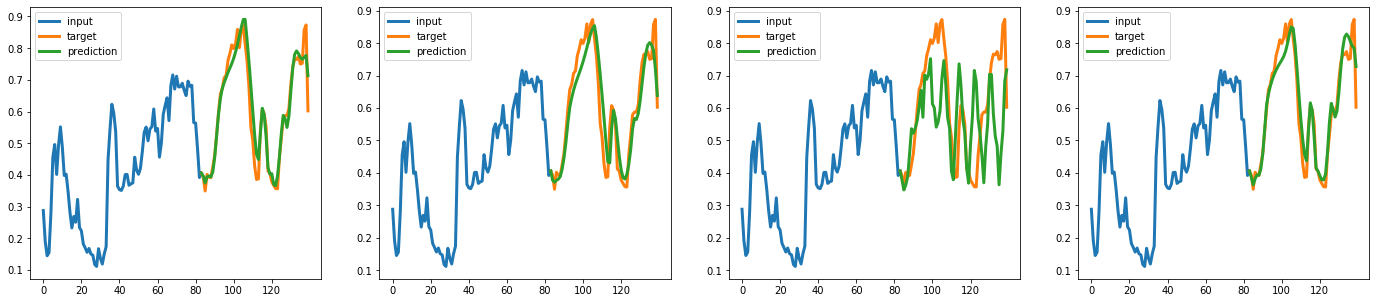

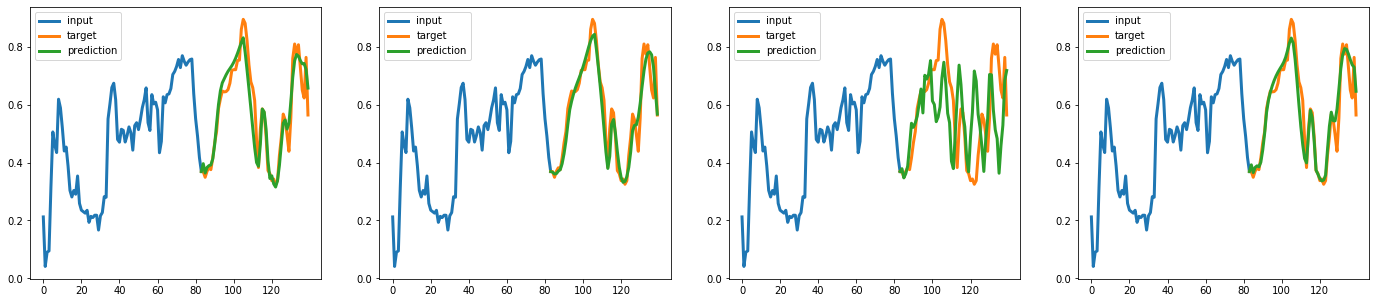

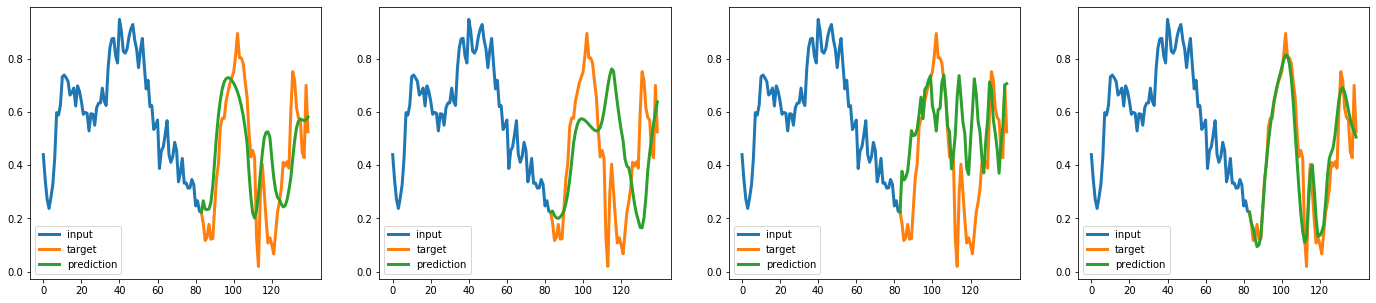

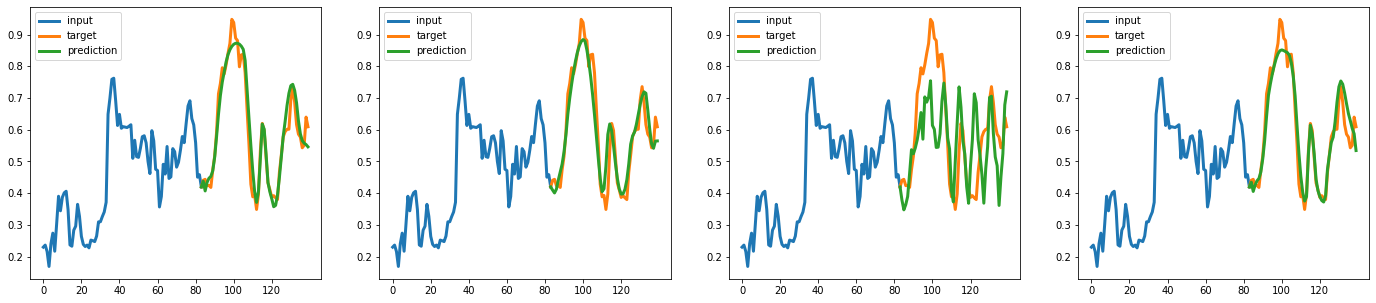

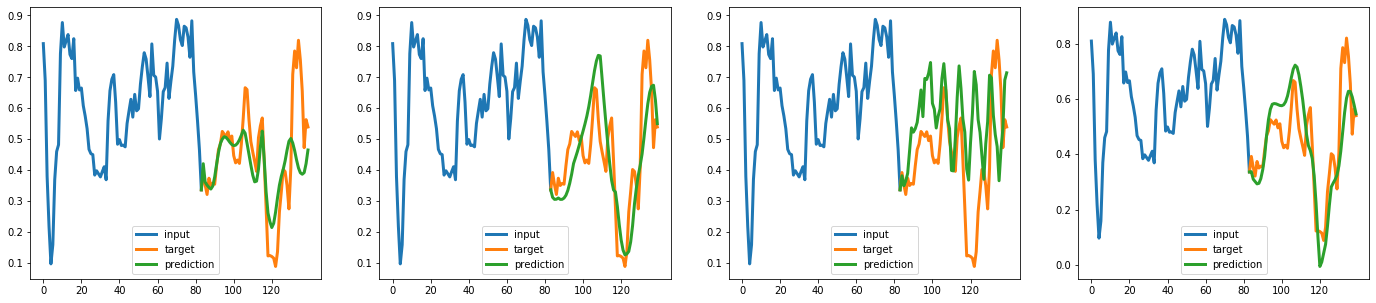

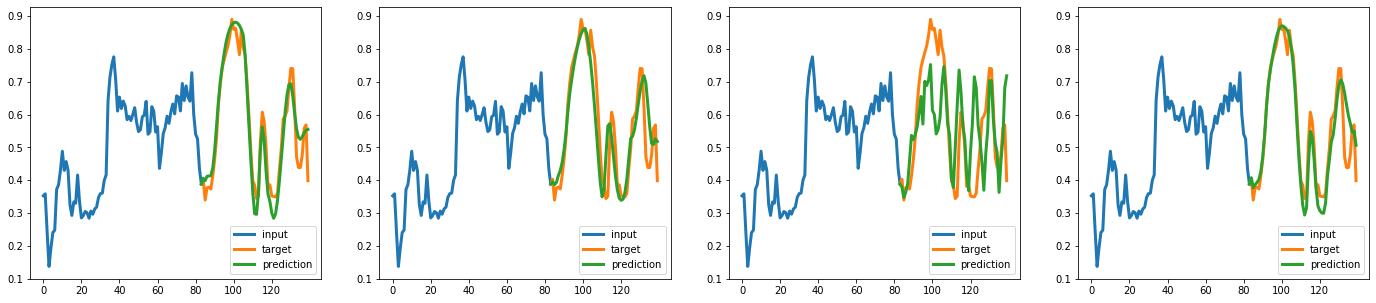

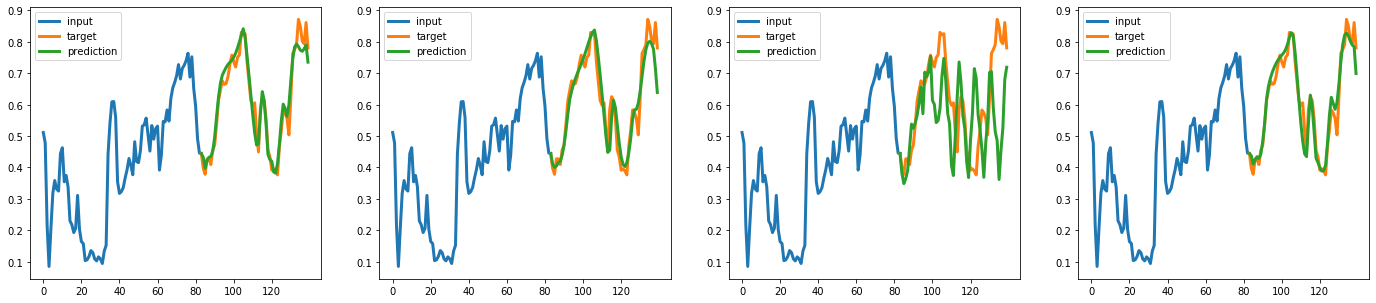

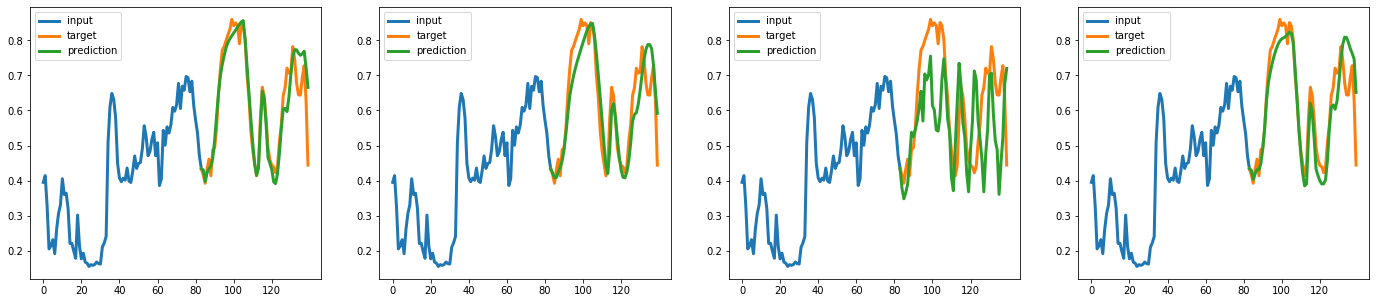

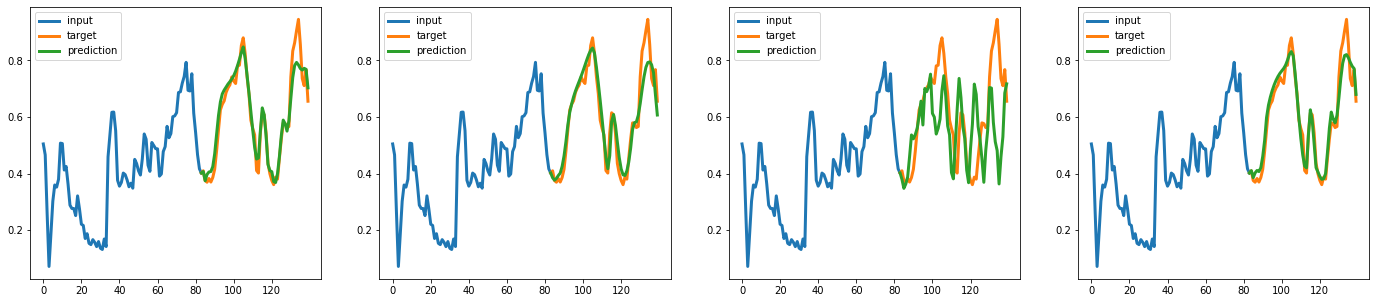

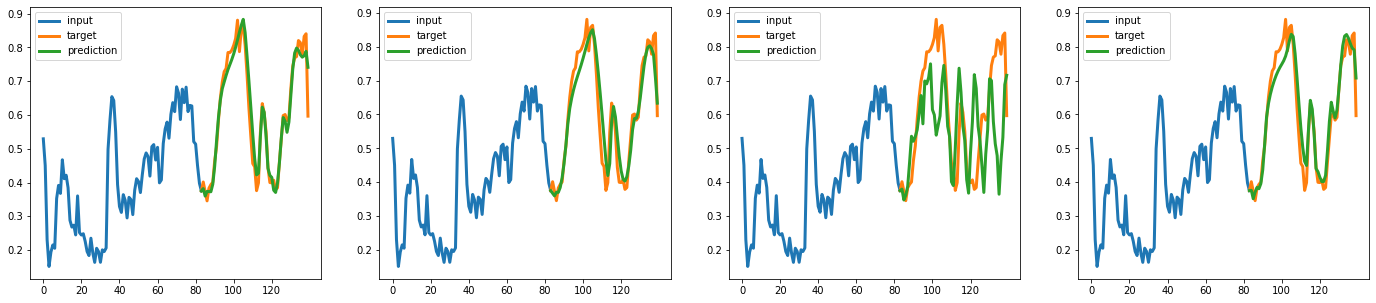

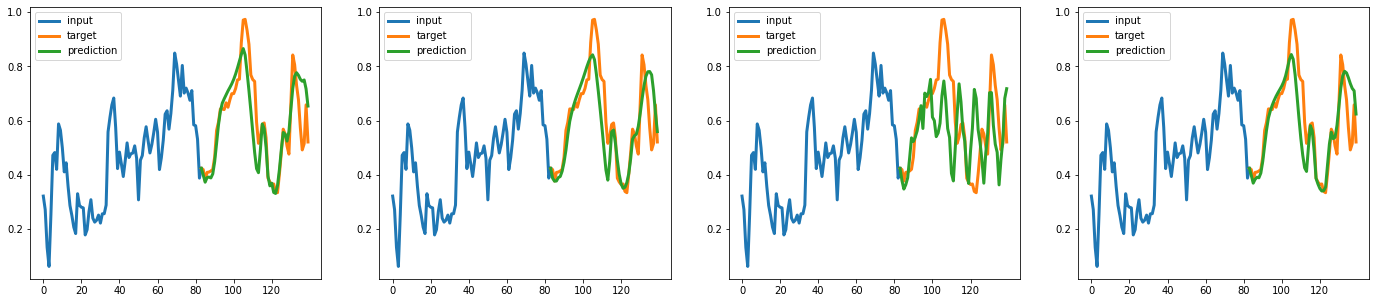

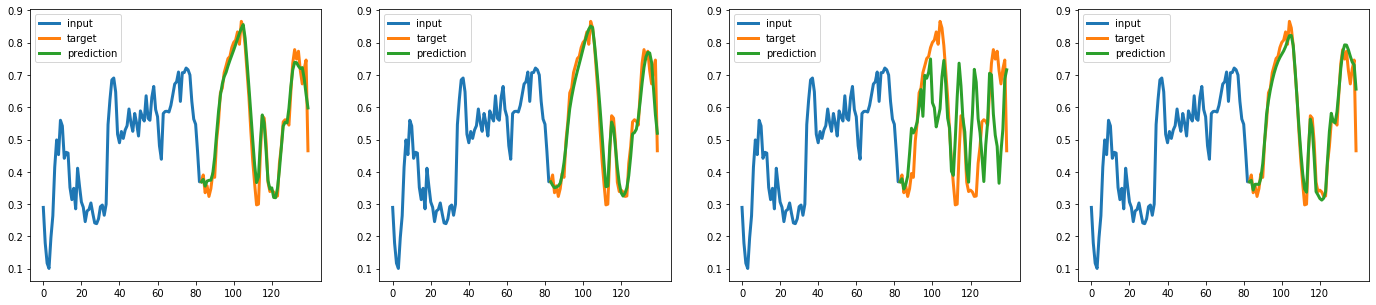

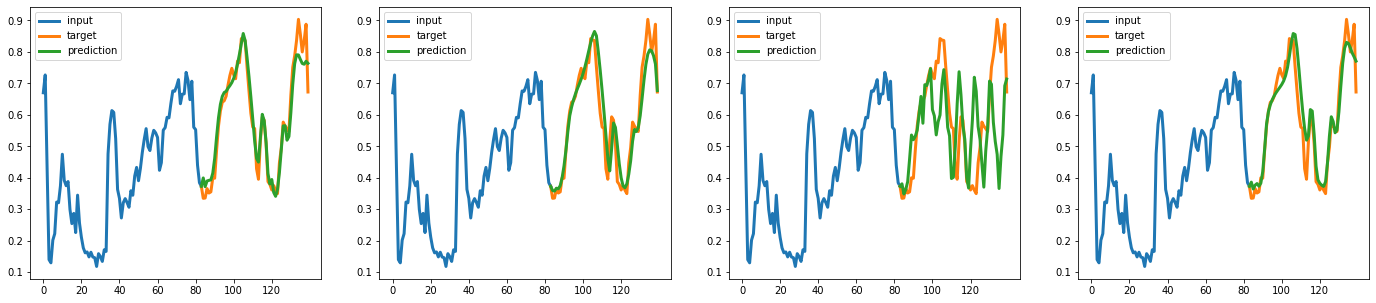

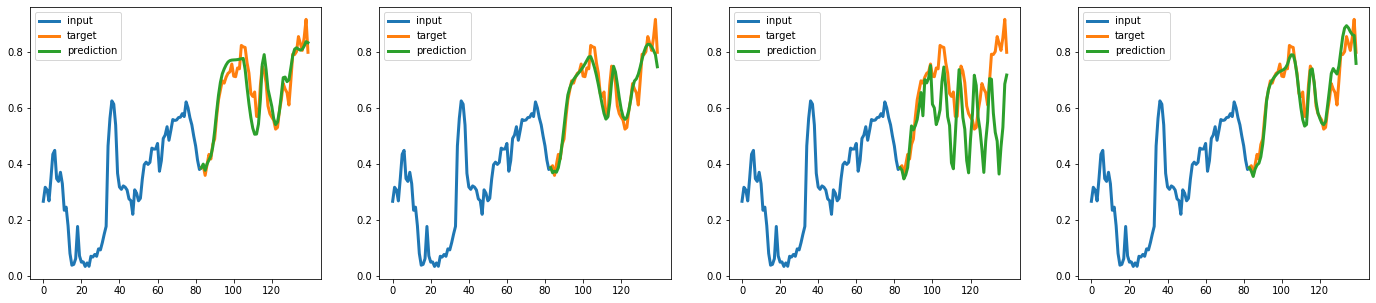

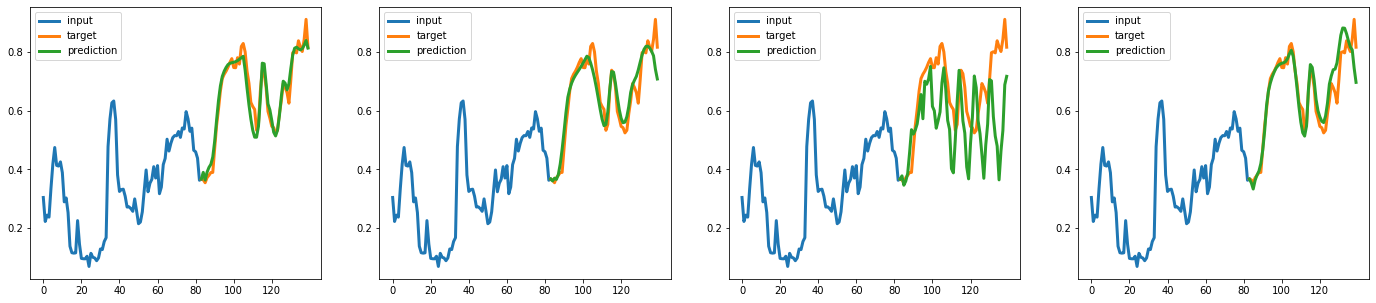

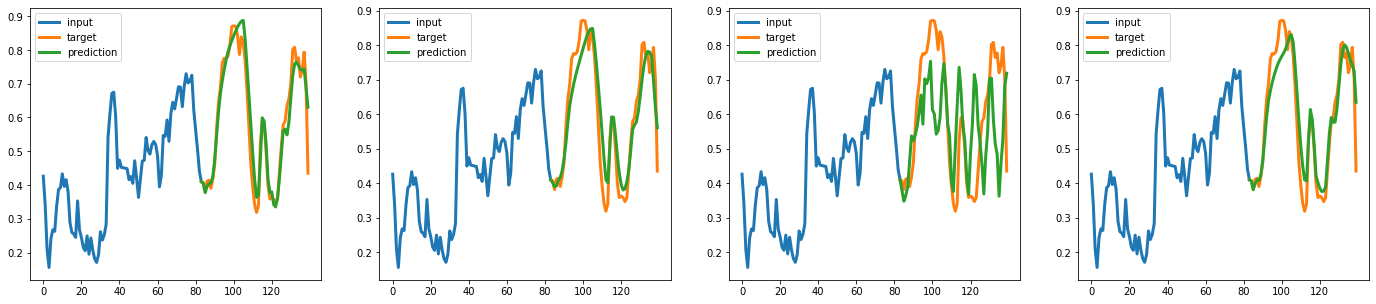

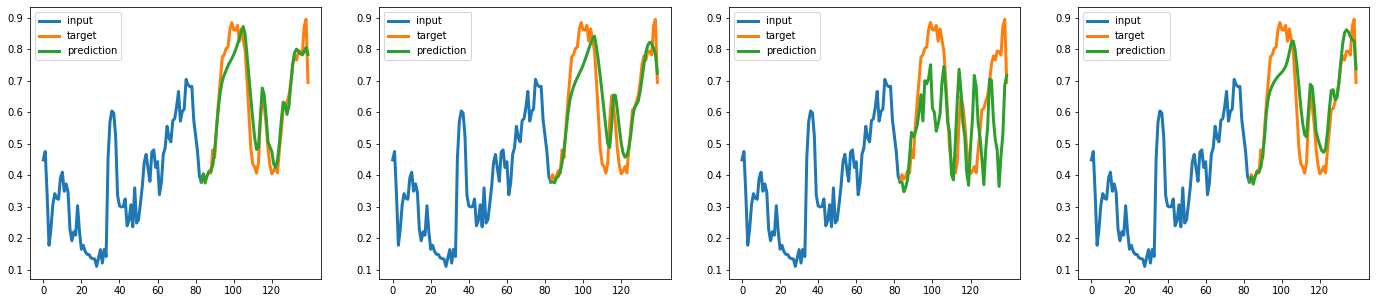

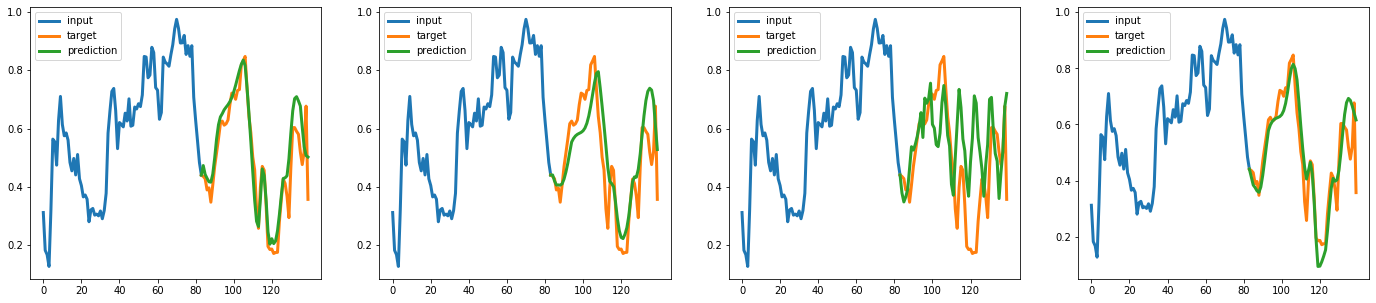

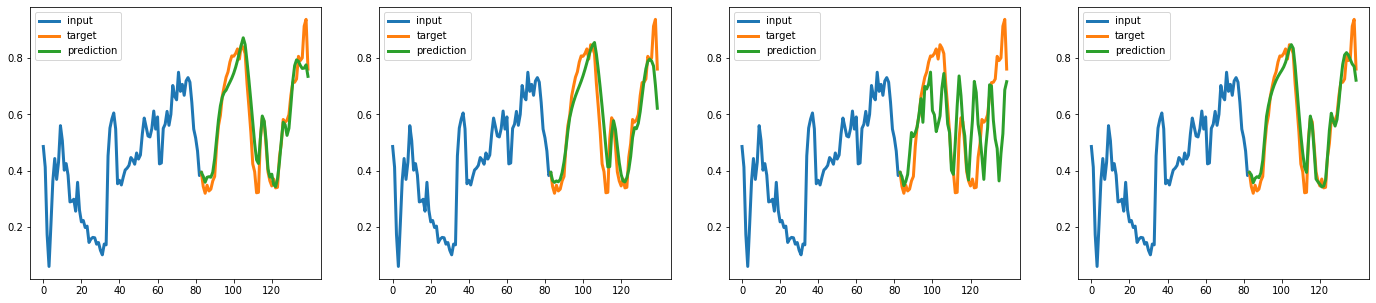

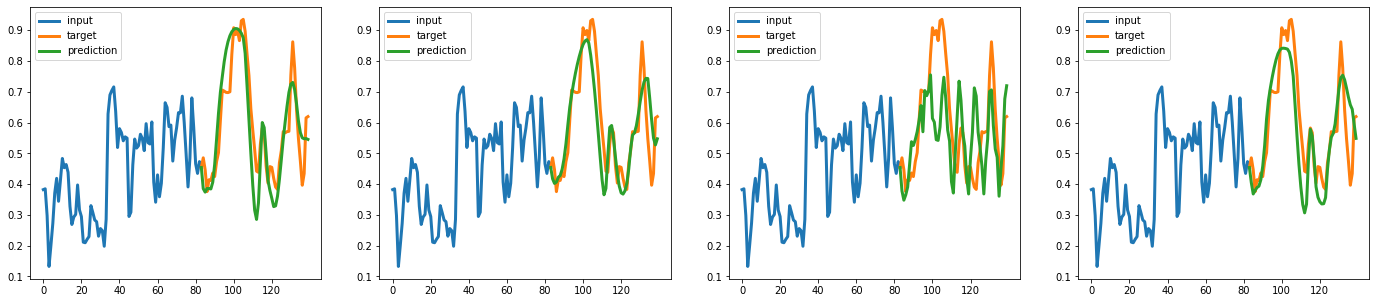

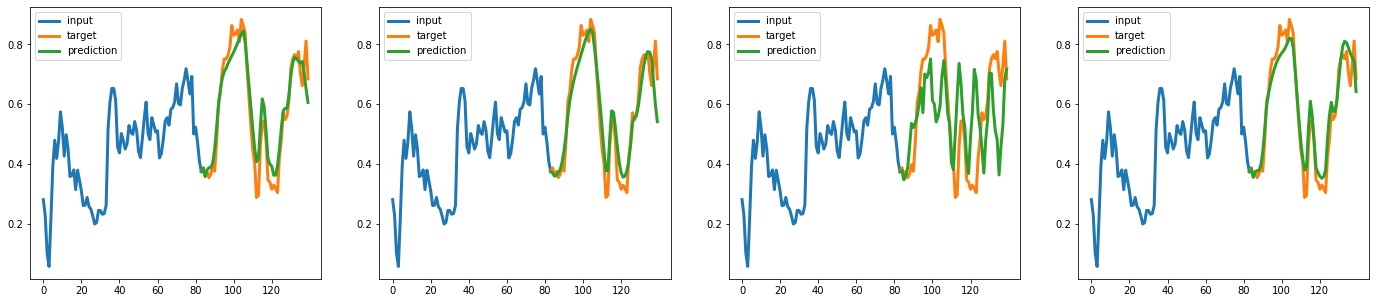

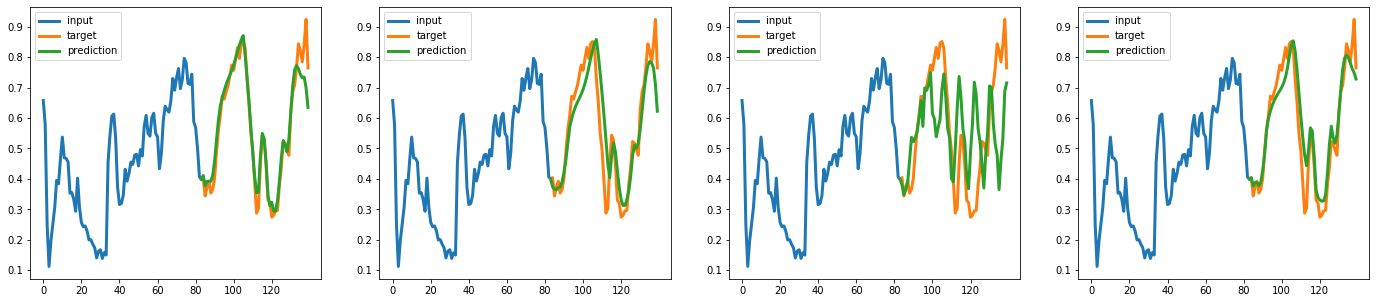

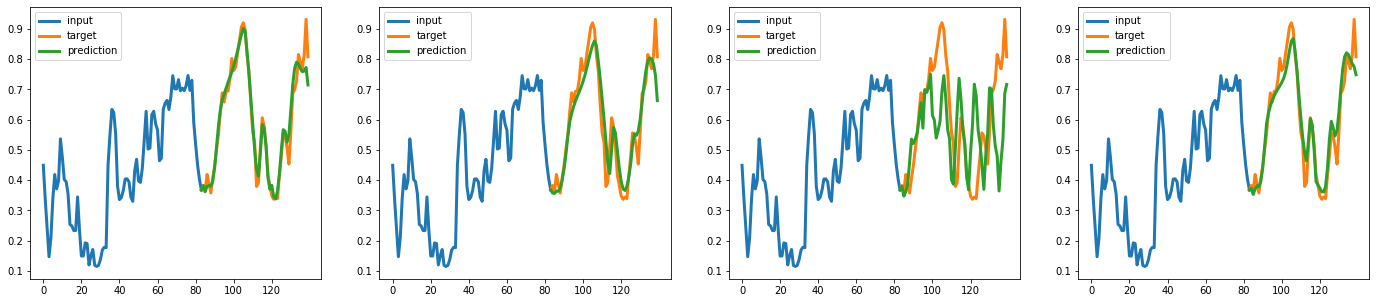

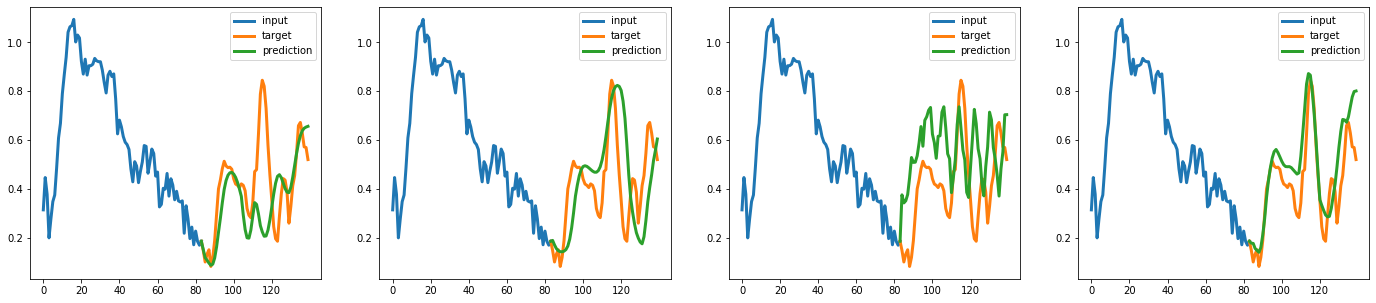

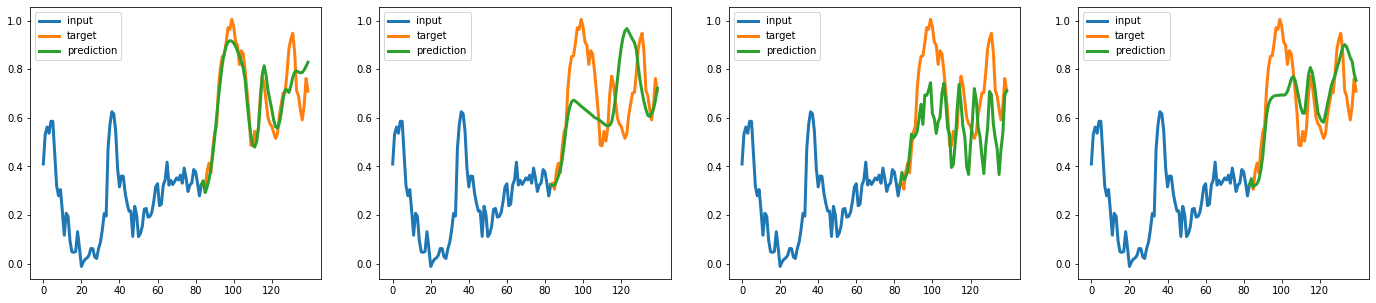

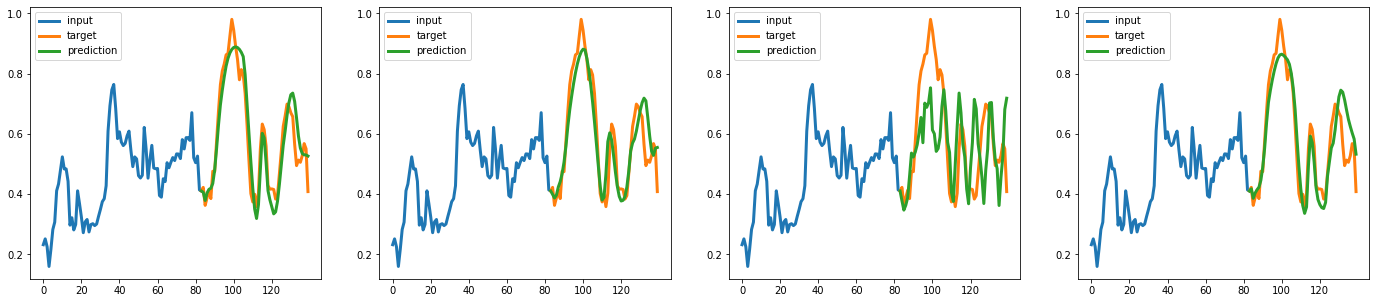

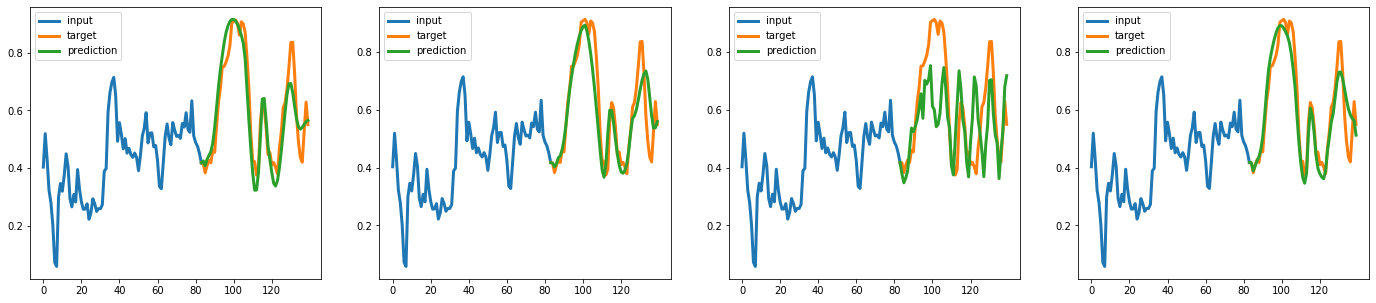

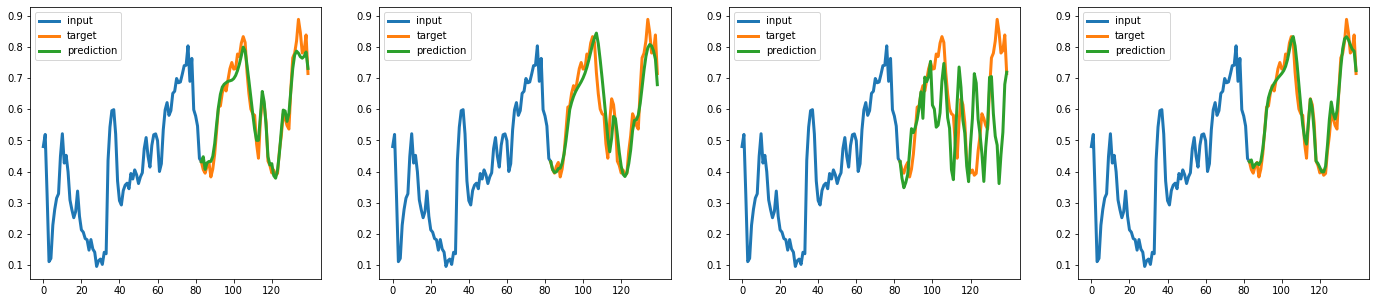

In [6]:
# Visualize results
gen_test = iter(testloader)
test_inputs, test_targets, breaks = next(gen_test)

test_inputs  = torch.tensor(test_inputs, dtype=torch.float32).to(device)
test_targets = torch.tensor(test_targets, dtype=torch.float32).to(device)
criterion = torch.nn.MSELoss()

nets = [net_gru_mse,net_gru_dilate_shape,net_gru_dilate,net_gru_huber]

for ind in range(1,51):
    plt.figure()
    plt.rcParams['figure.figsize'] = (24.0,5.0)  
    k = 1
    for net in nets:
        pred = net(test_inputs).to(device)

        input = test_inputs.detach().cpu().numpy()[ind,:,:]
        target = test_targets.detach().cpu().numpy()[ind,:,:]
        preds = pred.detach().cpu().numpy()[ind,:,:]

        plt.subplot(1,4,k)
        plt.plot(range(0,N_input) ,input,label='input',linewidth=3)
        plt.plot(range(N_input-1,N_input+N_output), np.concatenate([ input[N_input-1:N_input], target ]) ,label='target',linewidth=3)   
        plt.plot(range(N_input-1,N_input+N_output),  np.concatenate([ input[N_input-1:N_input], preds ])  ,label='prediction',linewidth=3)       
        plt.xticks(range(0,N_input+N_output,20))
        plt.legend()
        k = k+1

    plt.show()